In [11]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Data Preparation

In [12]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

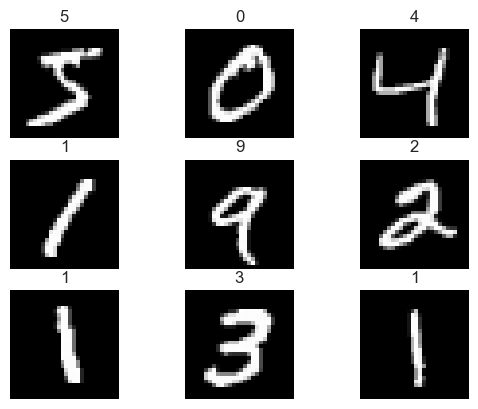

In [13]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.title(y_train[i])
plt.show()

In [14]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [15]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)

In [16]:
y_test = to_categorical(y_test)

# Model Building

In [18]:
from sklearn.model_selection import GridSearchCV
from keras.src.layers import Dense, BatchNormalization, Dropout
from keras.models import Sequential
from keras.layers import Flatten
from keras.optimizers import Adam

# keras tuner
from keras_tuner import RandomSearch
from keras_tuner import HyperParameters

def build_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=[28, 28, 1]))
    for i in range(hp.Int('n_hidden', 2, 4)):
        model.add(Dense(units=hp.Int('n_neurons', 10, 100, 10), activation=hp.Choice('activation', ['relu', 'elu', 'tanh'])))
        model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Choice('dropout_rate', [0.1, 0.2, 0.3, 0.4, 0.5])))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', [0.01, 0.001, 0.0001])), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='mnist'
)
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Trial 5 Complete [00h 00m 57s]
val_accuracy: 0.9575666785240173

Best val_accuracy So Far: 0.970633347829183
Total elapsed time: 00h 05m 39s


In [19]:
best_model = tuner.get_best_models()[0]
best_model.summary()

C:\Users\Wojciech\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 80)             │        62,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 80)             │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 80)             │         6,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 80)             │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 80)             │         6,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 80)             │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 80)             │         6,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 80)             │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,330 (329.41 KB)

 Trainable params: 83,690 (326.91 KB)

 Non-trainable params: 640 (2.50 KB)

In [20]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'n_hidden': 4,
 'n_neurons': 80,
 'activation': 'relu',
 'dropout_rate': 0.1,
 'learning_rate': 0.0001}

# Best hyperparameters
n_hidden: 4,
n_neurons: 80,
activation: 'relu',
dropout_rate: 0.1,
learning_rate: 0.0001

# Model Training

In [22]:
best_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
history = best_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9324 - loss: 0.2213 - val_accuracy: 0.9639 - val_loss: 0.1263
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9469 - loss: 0.1743 - val_accuracy: 0.9691 - val_loss: 0.1007
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9536 - loss: 0.1491 - val_accuracy: 0.9732 - val_loss: 0.0882
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9598 - loss: 0.1358 - val_accuracy: 0.9726 - val_loss: 0.0976
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9605 - loss: 0.1324 - val_accuracy: 0.9738 - val_loss: 0.0865
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9629 - loss: 0.1191 - val_accuracy: 0.9742 - val_loss: 0.0766
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9646 - loss: 0.1116 - val_accuracy: 0.9756 - val_loss: 0.0777
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9681 - loss: 0.1037 - 

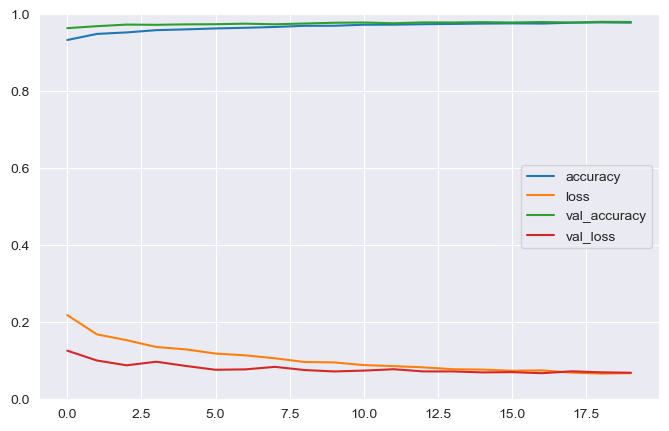

In [24]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [25]:
y_pred = best_model.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step


In [26]:
y_pred = np.argmax(y_pred, axis=1)

In [27]:
y_test = np.argmax(y_test, axis=1)

In [28]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.98

# Accuracy: 0.98

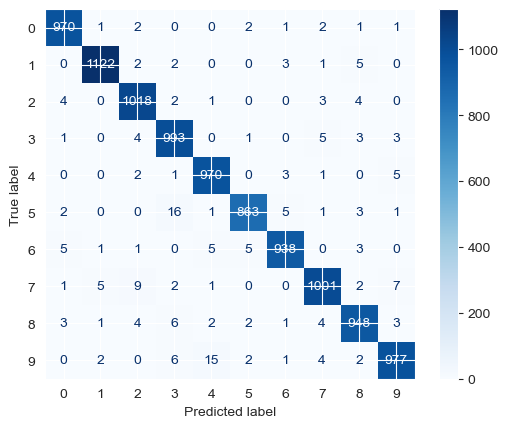

In [29]:
from sklearn import metrics
# change colors
confusion_matrix = metrics.confusion_matrix(y_test, y_pred, labels=np.arange(10))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = np.arange(10),)

cm_display.plot(cmap='Blues', values_format='d')
plt.show()

# Saving model

In [30]:
best_model.save('mnist_nn2.keras')